In [1]:
from glob import glob
import json
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from scipy import interpolate, ndimage, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind

In [4]:
%matplotlib qt

Channels marked as bad:
none
Channels marked as bad:
none


#### Plot electrodes

## Functions

In [5]:
def prune_close_peaks(peak_times, peak_amplitudes, minimum_peak_separation=0.08):
    """
    This function is designed to remove extra peaks that are marking the same SWD spike due to varying voltage around the spike.

    Inputs:
    ----------
    peak_times : array_like
        An array/list of peak times.
    peak_amplitudes : array_like
        An array/list of peak amplitudes, must be positive amplitudes.
    minimum_peak_separation : float, default=0.08
        The minimum time separation (s) you would expect to find consecutive spikes in the SWD. Peaks that are found with intervals less than this
        are grouped and pruned to the one peak with the maximum amplitude.

    Outputs:
    ----------
    pruned_peak_times : array
        An array of peak times after removing double+ peaks.
    """
    pruned_peak_times = []
    # Start first group
    close_times = [peak_times[0]]
    close_amps  = [peak_amplitudes[0]]
    for t, a in zip(peak_times[1:], peak_amplitudes[1:]):
        # If this peak is close to the previous one, group it
        if t - close_times[-1] < minimum_peak_separation:
            close_times.append(t)
            close_amps.append(a)
        else:
            # Commit the max-amplitude peak of the previous group
            idx = np.argmax(close_amps)
            pruned_peak_times.append(close_times[idx])
            # Start new group
            close_times = [t]
            close_amps  = [a]
    # Commit last group
    idx = np.argmax(close_amps)
    pruned_peak_times.append(close_times[idx])
    return np.array(pruned_peak_times)

def group_peaks(swd_spike_times, initial_ISI_threshold=0.2, other_ISI_threshold=0.35):
    """
    This function groups peaks into potential SWD events based on the following criteria:
        - the first two spikes in an event have an ISI < initial_ISI_threshold (McCafferty et al. used 0.2 s)
        - any other spikes in the event have ISI < other_ISI_threshold (McCafferty et al. used 0.35 s)

    Inputs:
    ----------
    swd_spike_times : array_like
        An array/list of peak times.
    initial_ISI_threshold : float, default=0.2
        The maximum time separation (s) between the first two spikes in the SWD.
    other_ISI_threshold : float, default=0.35
        The maximum time separation (s) between the remaining spikes in the SWD.

    Outputs:
    ----------
    grouped_spikes : list
        A list of events, each of which is list of SWD spike times that meet the ISI criteria.
    """
    grouped_spikes = []
    temp_group = [swd_spike_times[0]]
    for t in swd_spike_times[1:]:
        if (len(temp_group) == 1) and (t - temp_group[-1] < initial_ISI_threshold): # if this is the second spike in SWD, use initial threshold
            temp_group.append(t)
        elif (len(temp_group) > 1) and (t - temp_group[-1] < other_ISI_threshold): # if this is the third+ spike in SWD, use relaxed threshold
            temp_group.append(t)
        else:
            grouped_spikes.append(temp_group) # if the spike ISI is greater than threshold, add group to event list
            temp_group = [t] # start the next possible event with this spike time
    grouped_spikes.append(temp_group) # add the final group
    return grouped_spikes

def events_to_SWDdf(possible_events, event_separation_threshold=0.5, minimum_spikes=5, minimum_SWD_duration=0.5):
    """
    This function sorts through potential SWD events. It combines events if they are closer in time than event_separation_threshold. If the number of
    spikes in the SWD is less than minimum_spikes or the SWD duration is less than minimum_SWD_duration, remove them from the list. Then turn the list
    into a pandas.DataFrame with the following event info: onset, offset, duration, spike_count, SWD_spike_times.

    Inputs:
    ----------
    possible_events : list
        A list of events, each of which is list of SWD spike times.
    event_separation_threshold : float, default=0.5
        If the time between two consecutive SWD events is less than event_separation_threshold, combine the two events.
    minimum_spikes : int, default=5
        Subselect SWD events that have at least minimum_spikes.
    minimum_SWD_duration : float, default=0.5
        Subselect SWD events that have a duration > minimum_SWD_duration.

    Outputs:
    ----------
    SWDdf : pandas.DataFrame
        Contains the SWD events that pass the above criteria and the following info: onset, offset, duration, spike_count, SWD_spike_times.
    """
    prune_events = []
    temp_combo = possible_events[0]
    for eventi in possible_events[1:]:
        if eventi[0] - temp_combo[-1] < event_separation_threshold: # if consecutive temp events are <0.5 s apart, combine them
            temp_combo.extend(eventi)
        else:
            if len(temp_combo) >= minimum_spikes: # if the event has enough spikes, keep the event
                prune_events.append(temp_combo)
            temp_combo = eventi # if consecutive temp events are >0.5 s apart, reset the temp event
    if len(temp_combo) >= minimum_spikes: # if the event has enough spikes, keep the event
        prune_events.append(temp_combo)
    SWD_info = []
    for eventi in prune_events:
        if eventi[-1] - eventi[0] > minimum_SWD_duration:
            SWD_info.append([eventi[0], eventi[-1], eventi[-1]-eventi[0], len(eventi), eventi])
    return pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])

def get_SWD_events(data, data_ts, data_sample_rate, stim_log=None, firstpass_std_multiple=1.5, secondpass_std_multiple=2.0):
    """
    This function is designed find SWD events on a given voltage signal (mainly EEG or LFP). It performs two rounds of peak finding: the first using 
    a relatively lenient threshold (using the mean + 1.5 * std of the first 5 min of recording); and the second pass uses a slightly stricter criteria
    (using the mean + 2 * std of the quiescent part of the recording, after removing stim times and possible SWDs identified in the first pass).

    Inputs:
    ----------
    data : array
        A 1-D array containing the data signal used to extract the SWD events.
    data_ts : array
        A 1-D array containing the timestamps (s) associated with the data_signal.
    data_sample_rate : float
        The sample rate for the data.
    stim_log : pandas.DataFrame
        A dataframe containing stimulus trial information, to exclude stimulus bouts from the pekak finding threshold.
    firstpass_std_multiple : float, default=1.5
        The multiplier for the standard deviation to set the first-pass peak threshold.
    secondpass_std_multiple : float, default=2.0
        The multiplier for the standard deviation to set the second-pass peak threshold.

    Outputs:
    ----------
    SWD_df : pandas.DataFrame
        An array of peak times after removing double+ peaks.
    """
    ### Set parameters ###
    smooth_time = 0.001 # in s, McCafferty uses +/-10 ms
    DC_subtraction_time = 0.1 # in s, McCafferty uses [-0.1, +0.11] s
    firstpass_window = [0, 300] # in s, window to get first-pass peak threshold
    
    ### First apply smoothing using a rolling average ###
    smooth_samples = int(smooth_time * data_sample_rate * 2)
    clean_data = signal.filtfilt(b=np.ones(smooth_samples) / smooth_samples, a=[1], x=data)
    ### Next apply DC subtraction using a rolling average over a wider window ###
    DC_samples = int(DC_subtraction_time * data_sample_rate * 2)
    DC_average = signal.filtfilt(b=np.ones(DC_samples) / DC_samples, a=[1], x=clean_data)
    clean_data = clean_data - DC_average

    ### Perform first-pass peak finding ###
    data_slice = clean_data[np.nonzero((data_ts > data_ts[0] + firstpass_window[0]) & (data_ts < data_ts[0] + firstpass_window[1]))[0]]
    first_peak_threshold = np.mean(data_slice) + (firstpass_std_multiple * np.std(data_slice))
    firstpass_peaks, _ = signal.find_peaks(-clean_data, first_peak_threshold)
    ## Prune the double+ peaks and get possible events ##
    firstpass_peaks = prune_close_peaks(data_ts[firstpass_peaks], -(clean_data[firstpass_peaks]))
    possible_SWD_events = group_peaks(firstpass_peaks)

    ### Use first-pass events to remove possible SWDs and stim times ###
    quiescent_data = clean_data.copy()
    ## Remove stim sessions from signal ##
    if stim_log is not None:
        for sweepi in np.unique(stim_log.sweep.values):
            sweepdf = stim_log[stim_log['sweep'] == sweepi]
            for stimtype in np.unique(sweepdf.stim_type.values):
                stimdf = sweepdf[sweepdf['stim_type'] == stimtype]
                stiminds = np.nonzero((data_ts > stimdf.onset.values[0]) & (data_ts < stimdf.offset.values[-1]))[0]
                quiescent_data[stiminds] = np.nan
    ## Remove possible SWDs from signal ##
    for spikelist in possible_SWD_events:
        if len(spikelist) > 2: # selects possible events with more than 2 peaks
            eventinds = np.nonzero((data_ts > spikelist[0] - 0.2) & (data_ts < spikelist[-1] + 0.2))[0] # buffer possible SWD by 0.2 s before/after
            quiescent_data[eventinds] = np.nan

    ### Perform second-pass peak finding ###
    second_peak_threshold = np.nanmean(quiescent_data) + (secondpass_std_multiple * np.nanstd(quiescent_data))
    secondpass_peaks, _ = signal.find_peaks(-clean_data, second_peak_threshold)
    ## Prune the double+ peaks and get possible events ##
    secondpass_peaks = prune_close_peaks(data_ts[secondpass_peaks], -(clean_data[secondpass_peaks]))
    possible_SWD_events = group_peaks(secondpass_peaks)
    return events_to_SWDdf(possible_SWD_events), clean_data

### Load experiment

In [6]:
recfolder = r'E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


In [49]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v2.pkl')
if os.path.exists(auto_annot_file):
    print('{} already exists, change name or overwrite existing.'.format(auto_annot_file))

E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1\autoSWDs_v2.pkl already exists, change name or overwrite existing.


### Load EEG data

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
print(eeg_ts[0])
print(eeg_ts[-1])
print(len(eeg_ts))

29.28925969205335
4379.753079310185
10876160


In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # print(stim_log.head())
else:
    stim_log = None
    print('No stim log found.')

Load manual annotations, too

### Get SWDs from auto annotation

In [12]:
test_ch = 20
startt = time.time()
autoSWD_df, cleaned_data = get_SWD_events(
    eeg_data[:, test_ch], eeg_ts, exp.ephys_params['EEG']['sample_rate'], stim_log=stim_log, firstpass_std_multiple=1.5, secondpass_std_multiple=2.5
)
endt = time.time()
print('Time to process SWDs: {:.2f} s'.format(endt-startt))

Time to process SWDs: 41.22 s


In [13]:
autoSWD_df.head()

onset     offset  duration  spike_count  \
0  30.672067  32.047274  1.375207           10   
1  34.455686  36.509697  2.054011           14   
2  37.022100  39.317712  2.295612           14   
3  40.148516  43.607734  3.459218           19   
4  44.875340  47.865356  2.990015           19   

                                     SWD_spike_times  
0  [30.67206683682962, 30.912068076883358, 31.056...  
1  [34.45568638627677, 34.5868870641728, 34.72408...  
2  [37.02209964658471, 37.20370058489203, 37.3577...  
3  [40.148515800351376, 40.25491635010853, 40.723...  
4  [44.87534022320969, 45.03494104784542, 45.1573...

In [48]:
print(len(autoSWD_df))

856


In [50]:
autoSWD_df.to_pickle(auto_annot_file)
print('Saved {}'.format(auto_annot_file))

Saved E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1\autoSWDs_v2.pkl


### Create MNE Raw object and plot annotated SWDs

Create MNE Raw object and plot annotated SWDs.
<br>Add EEG signals to the MNE Raw object.

In [15]:
plot_eeg_chs = np.array([6, 9, 11, 13, 16, 18, 20, 23]) # could also set equal to eeg_chs
ch_names = ['EEG'+str(x) for x in plot_eeg_chs]
data_array = eeg_data.T[plot_eeg_chs, :] * 1e-6
print(data_array.shape)

(8, 10876160)


Add LFP signals to the MNE Raw object.

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
if len(probe_list) > 0:
    for probei in probe_list:
        with open(exp.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        surface_ch = int(data['surface_channel'])
        probe_areas = np.array(data['area_ch'])

        lfp_ch = surface_ch - 50
        lfp_ch_name = probei[-1] + str(lfp_ch) + '-' + probe_areas[lfp_ch][:3]
        print(lfp_ch_name)
        ch_names.append(lfp_ch_name)
        ## Load LFP as memmap ##
        lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
        lfp_data_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r').reshape(
            (len(lfp_ts), exp.ephys_params[probei]['num_chs']))
        lfp_raw_data = lfp_data_mm[:, lfp_ch] * exp.ephys_params[probei]['bit_volts'] * 1e-6

        ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
        hardware_filter = signal.butter(1, Wn=[0.5, 100], btype='band', fs=exp.ephys_params[probei]['lfp_sample_rate'])
        lfp_raw_data = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_raw_data)))

        ## Align to EEG ##
        if lfp_ts[0] - eeg_ts[0] > 0:
            print(' LFP started late')
            match_ind = find_nearest_ind(eeg_ts, lfp_ts[0])
            aligned_lfp = np.insert(lfp_raw_data, 0, np.zeros((match_ind)))[:len(eeg_ts)]
            data_array = np.concatenate((data_array, aligned_lfp[np.newaxis, :]), axis=0)
        else:
            print(' LFP started early, what to do now?')
print(data_array.shape)

B318-SSp
 LFP started late
C314-VIS
 LFP started late
F317-MOp
 LFP started late
(11, 10876160)


Add population firing rate from each probe to the MNE Raw object.

In [17]:
ctx_areas = ['MO', 'SS', 'VIS']
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
    unit_info['ctx'] = [np.any([True if y in x else False for y in ctx_areas]) for x in unit_info['region'].values]
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

unit_id   probe  peak_ch  depth  spike_duration region  CCF_AP  CCF_DV  \
0      B0  probeB        0   3680        0.370854     PO     269     162   
1      B1  probeB        0   3680        0.398325     PO     269     162   
2      B2  probeB        0   3680        0.453266     PO     269     162   
3      B3  probeB        1   3680        0.384590     PO     269     162   
4      B4  probeB        1   3680        0.494472     PO     269     162   

   CCF_ML  firing_rate  presence_ratio  isi_viol  amplitude_cutoff  \
0     173     5.108656            0.99  0.788976          0.500000   
1     173    11.458331            0.99  0.160769          0.001680   
2     173     1.618910            0.99  1.446394          0.500000   
3     173     4.637902            0.99  0.100133          0.000948   
4     173     6.090622            0.99  0.048773          0.085176   

   spike_count parent_region    ctx  
0        22225            TH  False  
1        49849            TH  False  
2         7043            TH  False  
3        20177            TH  False  
4        26497            TH  False

In [18]:
eeg_bins = np.append(eeg_ts, eeg_ts[-1] + (1/exp.ephys_params['EEG']['sample_rate']))
for probei in probe_list:
    probe_units_df = unit_info[
        (unit_info['probe'] == probei) &
        (unit_info['ctx'] == True) &
        (unit_info['spike_count'] > 500)
    ]
    print('{}: {:d} units'.format(probei, len(probe_units_df)))
    if len(probe_units_df) > 15:
        allunitspikes = np.concatenate([all_unit_all_spikes[uidx]['spikes'] for uidx in probe_units_df.unit_id.values])
        allspikecounts, edges = np.histogram(np.sort(allunitspikes), eeg_bins)
        popSDF = ndimage.gaussian_filter(allspikecounts / (len(probe_units_df) / exp.ephys_params['EEG']['sample_rate']), sigma=10, output=float)
        ch_names.append(probei[-1] + 'units')
        data_array = np.concatenate((data_array, (popSDF / (np.max(popSDF)*5E2))[np.newaxis, :]), axis=0)

probeB: 195 units
probeC: 30 units
probeF: 258 units


### Create the MNE raw array

In [19]:
info = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
mne_raw = mne.io.RawArray(data_array, info)

Creating RawArray with float64 data, n_channels=14, n_times=10876160
    Range : 0 ... 10876159 =      0.000 ...  4350.464 secs
Ready.


Set annotations

In [22]:
my_annot = mne.Annotations(
    onset=autoSWD_df['onset'].values - eeg_ts[0], # onset in s, corrected to align with time zero
    duration=autoSWD_df['duration'].values,
    description=['SWDa'] * len(autoSWD_df)
)
mne_raw.set_annotations(my_annot)
print(mne_raw.annotations)

<Annotations | 856 segments: SWDa (856)>


#### Plot the signals with annotations

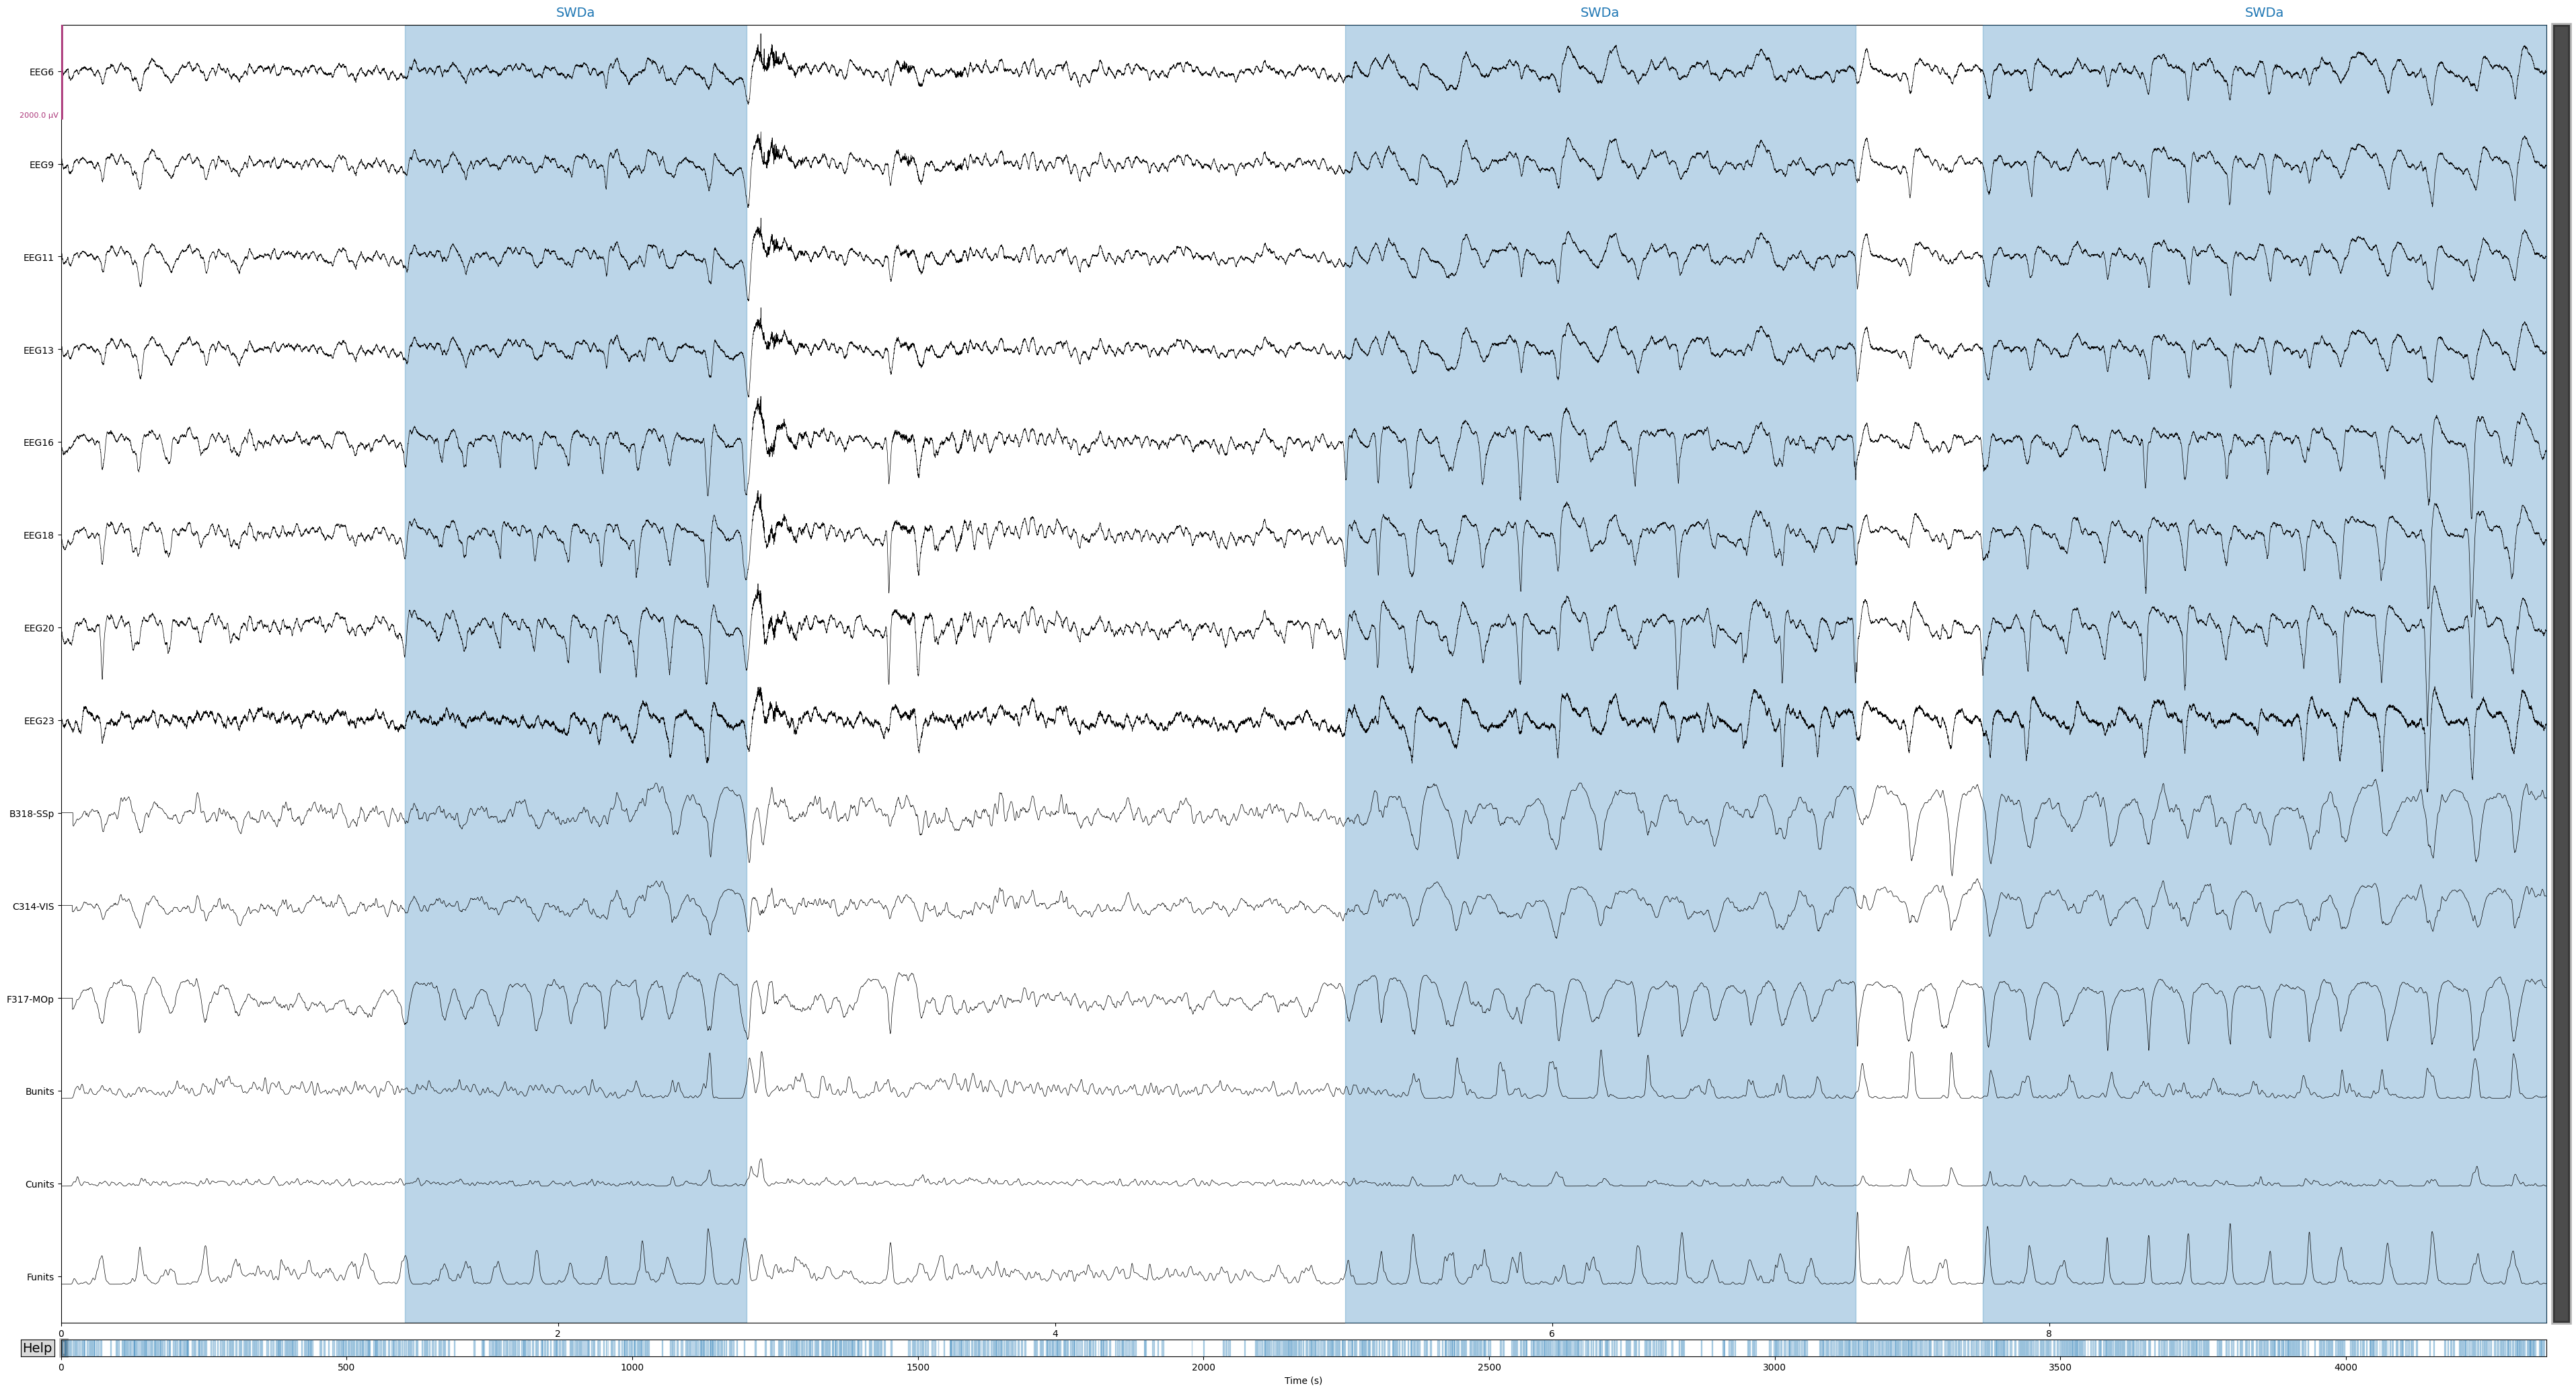

In [24]:
scalings = {'eeg': 1e-3}
mne_raw.plot(n_channels=data_array.shape[0], scalings=scalings)

In [25]:
print(mne_raw.annotations)
print(len(autoSWD_df))

<Annotations | 954 segments: SWDa (954)>
856


Now combine manually annotated events

In [29]:
manual_events = np.array([mne_raw.annotations.onset + eeg_ts[0], mne_raw.annotations.onset + eeg_ts[0] + mne_raw.annotations.duration]).T
print(manual_events.shape)

(954, 2)


In [34]:
event_separation_threshold=0.5
minimum_SWD_duration=0.5

prune_events = []
temp_event = list(manual_events[0])
for eventi in manual_events[1:]:
    if eventi[0] - temp_event[-1] < event_separation_threshold: # if consecutive temp events are <0.5 s apart, combine them
        temp_event = [temp_event[0], eventi[-1]]
    else:
        if temp_event[-1] - temp_event[0] > minimum_SWD_duration:
            prune_events.append(temp_event)
        temp_event = list(eventi)
if temp_event[-1] - temp_event[0] > minimum_SWD_duration:
    prune_events.append(temp_event)

In [38]:
manual_adjusted_SWDs = pd.DataFrame(prune_events, columns=['onset', 'offset'])
manual_adjusted_SWDs['duration'] = manual_adjusted_SWDs['offset'] - manual_adjusted_SWDs['onset']
print(len(manual_adjusted_SWDs))

639


In [40]:
manual_adjusted_SWDs.tail()

onset       offset   duration
634  4292.786890  4296.518504   3.731614
635  4298.554312  4308.826091  10.271778
636  4310.378067  4318.417447   8.039380
637  4319.942043  4322.625533   2.683490
638  4324.349514  4327.022684   2.673171

### Save auto annotations as a pickle file

In [42]:
manual_adjusted_SWDs.to_pickle(auto_annot_file)
print('Saved {}'.format(auto_annot_file))

Saved E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1\autoSWDs_v2.pkl


## Check the adjusted SWDs

In [43]:
info2 = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
mne_raw2 = mne.io.RawArray(data_array, info)
my_annot2 = mne.Annotations(
    onset=manual_adjusted_SWDs['onset'].values - eeg_ts[0], # onset in s, corrected to align with time zero
    duration=manual_adjusted_SWDs['duration'].values,
    description=['SWDadj'] * len(manual_adjusted_SWDs)
)
mne_raw2.set_annotations(my_annot2)
print(mne_raw2.annotations)

Creating RawArray with float64 data, n_channels=14, n_times=10876160
    Range : 0 ... 10876159 =      0.000 ...  4350.464 secs
Ready.
<Annotations | 639 segments: SWDadj (639)>


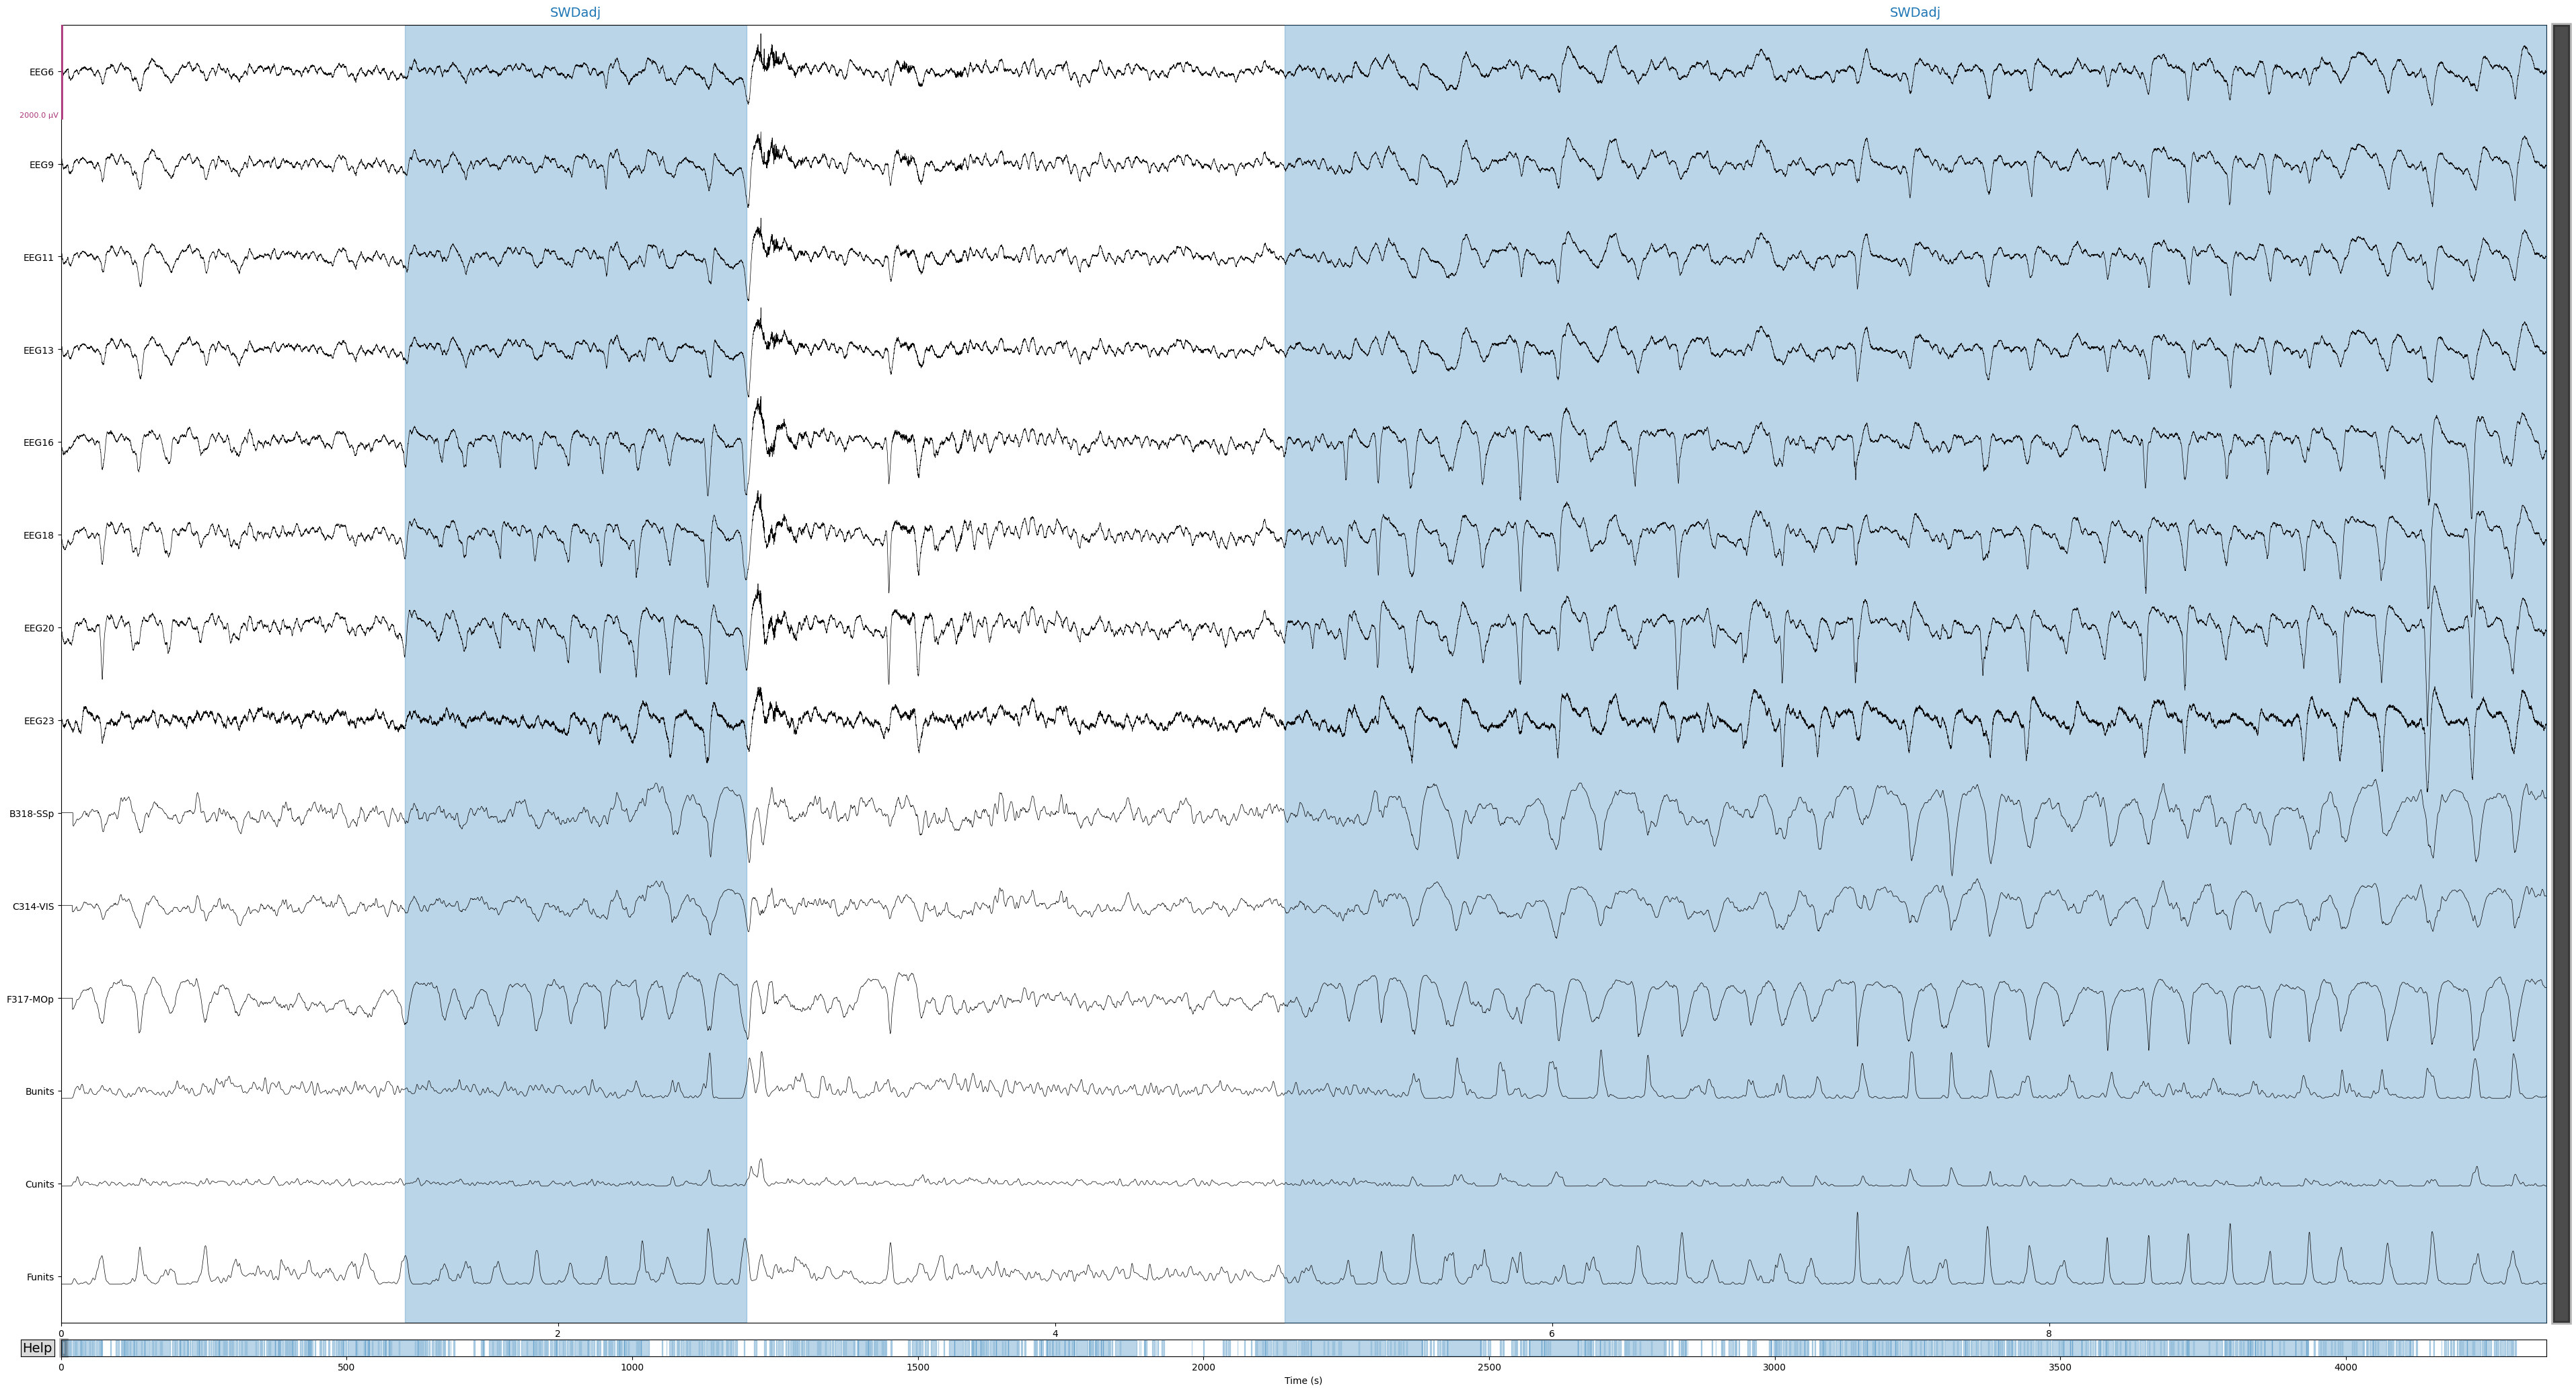

In [44]:
scalings = {'eeg': 1e-3}
mne_raw2.plot(n_channels=data_array.shape[0], scalings=scalings)

In [45]:
print(mne_raw2.annotations)
print(len(manual_adjusted_SWDs))

<Annotations | 538 segments: SWDadj (538)>
639


In [46]:
## Get 2nd manually adjusted events ##
manual_events_refined = np.array([mne_raw2.annotations.onset + eeg_ts[0], mne_raw2.annotations.onset + eeg_ts[0] + mne_raw2.annotations.duration]).T

## Prune events ##
prune_events = []
temp_event = list(manual_events_refined[0])
for eventi in manual_events_refined[1:]:
    if eventi[0] - temp_event[-1] < event_separation_threshold: # if consecutive temp events are <0.5 s apart, combine them
        temp_event = [temp_event[0], eventi[-1]]
    else:
        if temp_event[-1] - temp_event[0] > minimum_SWD_duration:
            prune_events.append(temp_event)
        temp_event = list(eventi)
if temp_event[-1] - temp_event[0] > minimum_SWD_duration:
    prune_events.append(temp_event)

## Create final SWD df ##
manual_adjusted_SWDs_2 = pd.DataFrame(prune_events, columns=['onset', 'offset'])
manual_adjusted_SWDs_2['duration'] = manual_adjusted_SWDs_2['offset'] - manual_adjusted_SWDs_2['onset']
print(len(manual_adjusted_SWDs_2))

531


In [47]:
auto_annot_file_adj = os.path.join(exp.data_folder, r'autoSWDs_adj_v2.pkl')
manual_adjusted_SWDs_2.to_pickle(auto_annot_file_adj)
print('Saved {}'.format(auto_annot_file_adj))

Saved E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1\autoSWDs_adj_v2.pkl


## Test adding LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeB
['CA1' 'CA2' 'CA3' 'DG-mo' 'LD' 'PO' 'SSp-tr1' 'SSp-tr2/3' 'SSp-tr4'
 'SSp-tr5' 'SSp-tr6a' 'SSp-tr6b' 'alv' 'ccb' 'cing' 'null' 'root']

probeC
['CA1' 'CA2' 'CA3' 'SSp-tr5' 'SSp-tr6a' 'SSp-tr6b' 'VISa1' 'VISa2/3'
 'VISa4' 'VISa5' 'VL' 'alv' 'ccb' 'fi' 'null' 'scwm']

probeF
['BST' 'CP' 'LSv' 'MOp1' 'MOp2/3' 'MOp5' 'MOp6a' 'MOp6b' 'VL' 'ccg' 'null'
 'scwm']



In [25]:
probe_name = 'probeF'
## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])
print('Surface ch: {:d}'.format(surface_ch))
area_chs = np.nonzero(probe_areas == 'MOp2/3')[0]
print(area_chs)

Surface ch: 367
[306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346]


In [60]:
lfp_ch = 360
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))
lfp_raw_data = lfp_data_mm[:, lfp_ch] * exp.ephys_params[probe_name]['bit_volts'] * 1e-6

How to align the LFP to the EEG

In [53]:
match_ind = find_nearest_ind(eeg_ts, lfp_ts[0])
print(match_ind)

116


In [61]:
aligned_lfp = np.insert(lfp_raw_data, 0, np.zeros((match_ind)))[:len(eeg_ts)]
print(len(aligned_lfp))
print(len(lfp_raw_data))

10876160
10876157


In [62]:
plot_eeg_chs = np.array([6, 9, 11, 13, 16, 18, 20, 23])
ch_names = ['EEG'+str(x) for x in plot_eeg_chs]
data_array = eeg_data.T[plot_eeg_chs, :] * 1e-3
print(data_array.shape)

(8, 10876160)


In [63]:
data_array = np.concatenate((data_array, aligned_lfp[np.newaxis, :]), axis=0)
print(data_array.shape)
ch_names.append('LFP-' + probe_name[-1] + str(lfp_ch))

(9, 10876160)


In [64]:
info = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
mne_raw = mne.io.RawArray(data_array, info)

Creating RawArray with float64 data, n_channels=9, n_times=10876160
    Range : 0 ... 10876159 =      0.000 ...  4350.464 secs
Ready.


In [65]:
my_annot = mne.Annotations(
    onset=autoSWD_df['onset'].values - eeg_ts[0], # onset in s, corrected to align with time zero
    duration=autoSWD_df['duration'].values,
    description=['SWDa'] * len(autoSWD_df)
)
mne_raw.set_annotations(my_annot);

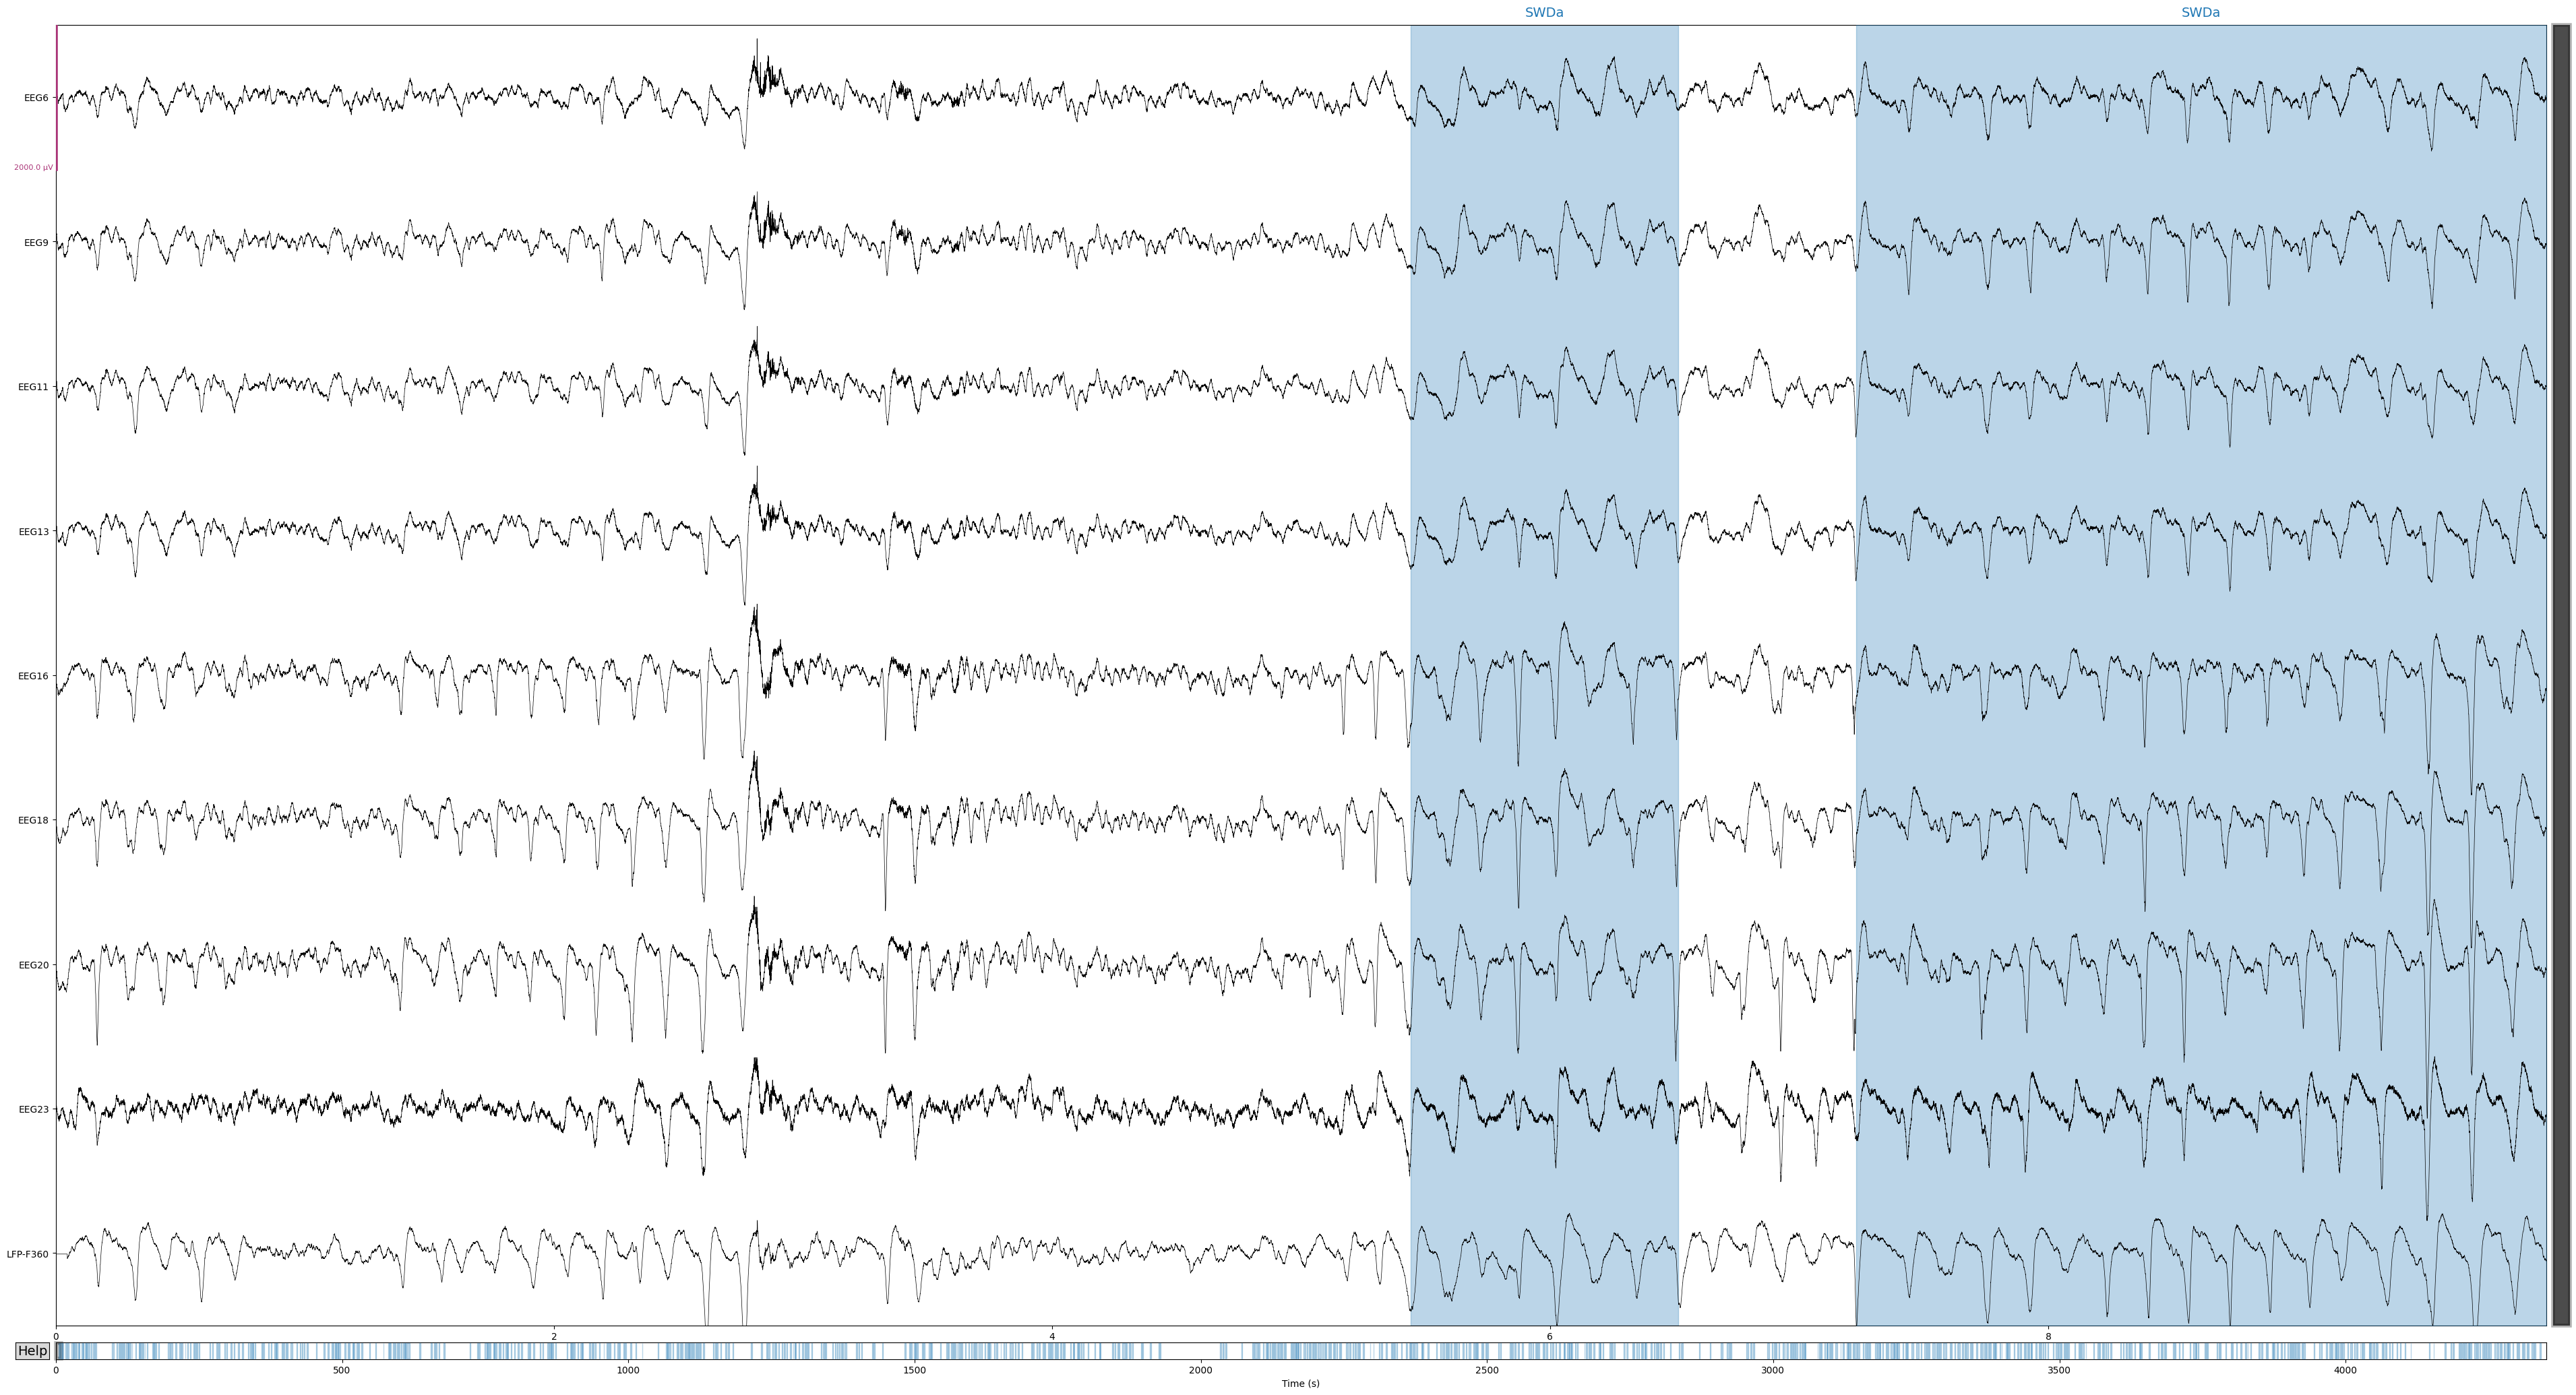

In [66]:
scalings = {'eeg': 1e-3}
mne_raw.plot(n_channels=10, scalings=scalings)

## Test adding population firing

In [17]:
ctx_areas = ['MO', 'SS', 'VIS']
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
    unit_info['ctx'] = [np.any([True if y in x else False for y in ctx_areas]) for x in unit_info['region'].values]
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

unit_id   probe  peak_ch  depth  spike_duration region  CCF_AP  CCF_DV  \
0      B0  probeB        0   3680        0.370854     PO     269     162   
1      B1  probeB        0   3680        0.398325     PO     269     162   
2      B2  probeB        0   3680        0.453266     PO     269     162   
3      B3  probeB        1   3680        0.384590     PO     269     162   
4      B4  probeB        1   3680        0.494472     PO     269     162   

   CCF_ML  firing_rate  presence_ratio  isi_viol  amplitude_cutoff  \
0     173     5.108656            0.99  0.788976          0.500000   
1     173    11.458331            0.99  0.160769          0.001680   
2     173     1.618910            0.99  1.446394          0.500000   
3     173     4.637902            0.99  0.100133          0.000948   
4     173     6.090622            0.99  0.048773          0.085176   

   spike_count parent_region    ctx  
0        22225            TH  False  
1        49849            TH  False  
2         7043            TH  False  
3        20177            TH  False  
4        26497            TH  False

In [18]:
eeg_bins = np.append(eeg_ts, eeg_ts[-1] + (1/exp.ephys_params['EEG']['sample_rate']))
for probei in probe_list:
    probe_units_df = unit_info[
        (unit_info['probe'] == probei) &
        (unit_info['ctx'] == True) &
        (unit_info['spike_count'] > 500)
    ]
    print('{}: {:d} units'.format(probei, len(probe_units_df)))
    if len(probe_units_df) > 15:
        allunitspikes = np.concatenate([all_unit_all_spikes[uidx]['spikes'] for uidx in probe_units_df.unit_id.values])
        allspikecounts, edges = np.histogram(np.sort(allunitspikes), eeg_bins)
        popSDF = ndimage.gaussian_filter(allspikecounts / (len(probe_units_df) / exp.ephys_params['EEG']['sample_rate']), sigma=10, output=float)
        ch_names.append(probei[-1] + 'units')
        data_array = np.concatenate((data_array, (popSDF / (np.max(popSDF)*5E2))[np.newaxis, :]), axis=0)

probeB: 195 units
probeC: 30 units
probeF: 258 units


### Plot manual vs. auto detections

In [21]:
bpb, bpa = signal.butter(3, np.array([3, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data[:, ex_ch], axis=0)

In [25]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(eeg_ts, filt_data, color='k', linewidth=1.0)
ax.set_xlim([eeg_ts[0], 445])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, SWDs'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind, swdrow in autoSWD_df.iterrows():
    ax.axvspan(swdrow['onset'], swdrow['offset'], 0, 0.5, color='g', alpha=0.2)
fig.show()